In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init, image
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

# 13. Computer Vision
Many applications in the area of computer vision are closely related to our daily lives, now and in the future, whether medical diagnostics, driverless vehicles, camera monitoring, or smart filters. In recent years, deep learning technology has greatly enhanced computer vision systems' performance. It can be said that the most advanced computer vision applications are nearly inseparable from deep learning.

We have introduced deep learning models commonly used in the area of computer vision in the chapter "Convolutional Neural Networks" and have practiced simple image classification tasks. In this chapter, we will introduce image augmentation and fine tuning methods and apply them to image classification. Then, we will explore various methods of object detection. After that, we will learn how to use fully convolutional networks to perform semantic segmentation on images. Then, we explain how to use style transfer technology to generate images that look like the cover of this book. Finally, we will perform practice exercises on two important computer vision datasets to review the content of this chapter and the previous chapters.

## 13.1 Image Augmentation
We mentioned that large-scale datasets are prerequisites for the successful application of deep neural networks in `Section 7.1`. Image augmentation technology expands the scale of training datasets by making a series of random changes to the training images to produce similar, but different, training examples. Another way to explain image augmentation is that randomly changing training examples can reduce a model's dependence on certain properties, thereby improving its capability for generalization. For example, we can crop the images in different ways, so that the objects of interest appear in different positions, reducing the model's dependence on the position where objects appear. We can also adjust the brightness, color, and other factors to reduce model's sensitivity to color. It can be said that image augmentation technology contributed greatly to the success of `AlexNet`. In this section, we will discuss this technology, which is widely used in computer vision.

### 13.1.1 Common Image Augmentation Method
In this experiment, we will use an image with a shape of $400\times 500$ as an example.

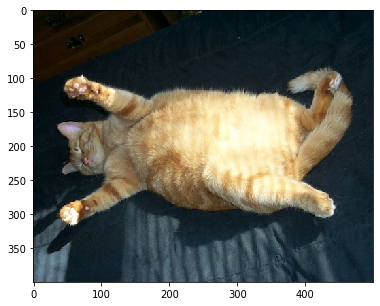

In [2]:
d2l.set_figsize()
img = image.imread('./images/cat1.jpg')
d2l.plt.imshow(img.asnumpy());

Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of image augmentation, we next define the auxiliary function apply. This function runs the image augmentation method `aug` multiple times on the input image `img` and shows all results.

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

##### Flipping and Cropping
Flipping the image left and right usually does not change the category of the object. This is one of the earliest and most widely used methods of image augmentation. Next, we use the `transforms` module to create the `RandomFlipLeftRight` instance, which introduces a `50%` chance that the image is flipped left and right.

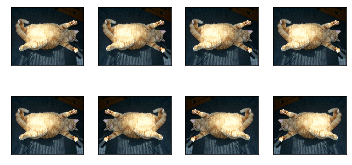

In [4]:
apply(img, gluon.data.vision.transforms.RandomFlipLeftRight())

Flipping up and down is not as commonly used as flipping left and right. However, at least for this example image, flipping up and down does not hinder recognition. Next, we create a `RandomFlipTopBottom` instance for a `50%` chance of flipping the image up and down.

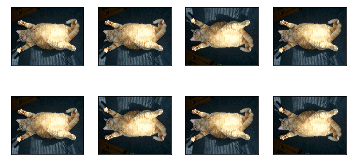

In [5]:
apply(img, gluon.data.vision.transforms.RandomFlipTopBottom())

In the example image we used, the cat is in the middle of the image, but this may not be the case for all images. In `Section 6.5`, we explained that the pooling layer can reduce the sensitivity of the convolutional layer to the target location. In addition, we can make objects appear at different positions in the image in different proportions by randomly cropping the image. This can also reduce the sensitivity of the model to the target position.

In the following code, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels. Unless otherwise stated, the random number between $a$ and $b$ in this section refers to a continuous value obtained by uniform sampling in the interval $[a, b]$.

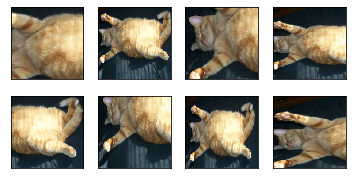

In [6]:
shape_aug = gluon.data.vision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

##### Changing the Color
Another augmentation method is changing colors. We can change four aspects of the image color: brightness, contrast, saturation, and hue. In the example below, we randomly change the brightness of the image to a value between `50%` ($1-0.5$) and `150%` ($1+0.5$) of the original image.

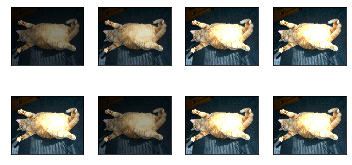

In [7]:
apply(img, gluon.data.vision.transforms.RandomBrightness(0.5))

Similarly, we can randomly change the hue of the image.

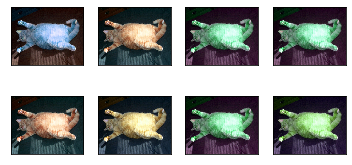

In [8]:
apply(img, gluon.data.vision.transforms.RandomHue(0.5))

We can also create a `RandomColorJitter` instance and set how to randomly change the brightness, contrast, saturation, and hue of the image at the same time.

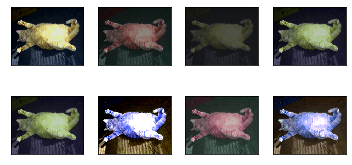

In [9]:
color_aug = gluon.data.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

##### Overlying Multiple Image Augmentation Methods
In practice, we will overlay multiple image augmentation methods. We can overlay the different image augmentation methods defined above and apply them to each image by using a `Compose` instance.

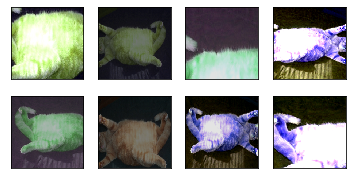

In [10]:
augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

### 13.1.2 Using an Image Augmentation Training Model
Next, we will look at how to apply image augmentation in actual training. Here, we use the `CIFAR-10` dataset, instead of the `Fashion-MNIST` dataset we have been using. This is because the position and size of the objects in the `Fashion-MNIST` dataset have been normalized, and the differences in color and size of the objects in `CIFAR-10` dataset are more significant. The first 32 training images in the `CIFAR-10` dataset are shown below.

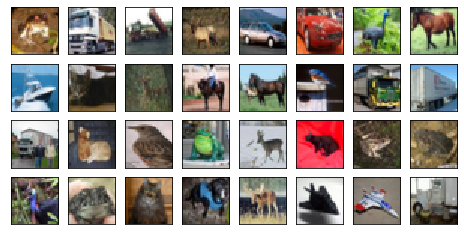

In [13]:
d2l.show_images(gluon.data.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=1);

In order to obtain definitive results during prediction, we usually only apply image augmentation to the training example, and do not use image augmentation with random operations during prediction. Here, we only use the simplest random left-right flipping method. In addition, we use a `ToTensor` instance to convert minibatch images into the format required by `MXNet`, i.e., 32-bit floating point numbers with the shape of `(batch size, number of channels, height, width)` and value range between 0 and 1.

In [14]:
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor()])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor()])

Next, we define an auxiliary function to make it easier to read the image and apply image augmentation. The `transform_first` function provided by `Gluon`'s dataset applies image augmentation to the first element of each training example (image and label), i.e., the element at the top of the image. For detailed descriptions of `DataLoader`, refer to `Section 3.5`.

In [15]:
def load_cifar10(is_train, augs, batch_size):
    return gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, 
        shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())

##### Using a Multi-GPU Training Model
We train the `ResNet-18` model described in `Section 7.6` on the `CIFAR-10` dataset. We will also apply the methods described in `Section 12.6` and use a multi-GPU training model.

Next, we define the training function to train and evaluate the model using multiple GPUs.

In [16]:
#@save
def train_batch_ch13(net, features, labels, loss, trainer, ctx_list, split_f=d2l.split_batch):
    X_shards, y_shards = split_f(features, labels, ctx_list)
    with autograd.record():
        pred_shards = [net(X_shard) for X_shard in X_shards]
        ls = [loss(pred_shard, y_shard) for pred_shard, y_shard
              in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    # The True flag allows parameters with stale gradients, which is useful
    # later (e.g., in fine-tuning BERT)
    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(d2l.accuracy(pred_shard, y_shard) 
                        for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum

In [17]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               ctx_list=d2l.try_all_gpus(), split_f=d2l.split_batch):
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, ctx_list, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0:
                animator.add(epoch + i / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(ctx_list)}')

Now, we can define the `train_with_data_aug` function to use image augmentation to train the model. This function obtains all available GPUs and uses `Adam` as the optimization algorithm for training. It then applies image augmentation to the training dataset, and finally calls the train function just defined to train and evaluate the model.

In [18]:
batch_size, ctx, net = 256, d2l.try_all_gpus(), d2l.resnet18(10)
net.initialize(init=init.Xavier(), ctx=ctx)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, ctx)

Now we train the model using image augmentation of random flipping left and right.

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

##### Summary
+ Image augmentation generates random images based on existing training data to cope with overfitting.
+ In order to obtain definitive results during prediction, we usually only apply image augmentation to the training example, and do not use image augmentation with random operations during prediction.
+ We can obtain classes related to image augmentation from Gluon's transforms module.

##### Exercises
1. Train the model without using image augmentation: `train_with_data_aug(no_aug, no_aug)`. Compare training and testing accuracy when using and not using image augmentation. Can this comparative experiment support the argument that image augmentation can mitigate overfitting? Why?
2. Add different image augmentation methods in model training based on the `CIFAR-10` dataset. Observe the implementation results.
3. With reference to the `MXNet` documentation, what other image augmentation methods are provided in `Gluon`'s transforms module?


## 13.2 Fine-Tuning
In earlier chapters, we discussed how to train models on the Fashion-MNIST training dataset, which only has 60,000 images. We also described ImageNet, the most widely used large-scale image dataset in the academic world, with more than 10 million images and objects of over 1000 categories. However, the size of datasets that we often deal with is usually larger than the first, but smaller than the second.

Assume we want to identify different kinds of chairs in images and then push the purchase link to the user. One possible method is to first find a hundred common chairs, take one thousand different images with different angles for each chair, and then train a classification model on the collected image dataset. Although this dataset may be larger than Fashion-MNIST, the number of examples is still less than one tenth of ImageNet. This may result in the overfitting of the complicated model applicable to ImageNet on this dataset. At the same time, because of the limited amount of data, the accuracy of the final trained model may not meet the practical requirements.

In order to deal with the above problems, an obvious solution is to collect more data. However, collecting and labeling data can consume a lot of time and money. For example, in order to collect the ImageNet datasets, researchers have spent millions of dollars of research funding. Although, recently, data collection costs have dropped significantly, the costs still cannot be ignored.

Another solution is to apply transfer learning to migrate the knowledge learned from the source dataset to the target dataset. For example, although the images in ImageNet are mostly unrelated to chairs, models trained on this dataset can extract more general image features that can help identify edges, textures, shapes, and object composition. These similar features may be equally effective for recognizing a chair.

In this section, we introduce a common technique in transfer learning: fine tuning. As shown in :numref:fig_finetune, fine tuning consists of the following four steps:

Pre-train a neural network model, i.e., the source model, on a source dataset (e.g., the ImageNet dataset).
Create a new neural network model, i.e., the target model. This replicates all model designs and their parameters on the source model, except the output layer. We assume that these model parameters contain the knowledge learned from the source dataset and this knowledge will be equally applicable to the target dataset. We also assume that the output layer of the source model is closely related to the labels of the source dataset and is therefore not used in the target model.
Add an output layer whose output size is the number of target dataset categories to the target model, and randomly initialize the model parameters of this layer.
Train the target model on a target dataset, such as a chair dataset. We will train the output layer from scratch, while the parameters of all remaining layers are fine-tuned based on the parameters of the source model.